In [1]:
# General
import xarray as xr    # handles netcdf data
import numpy as np     # numerical functions etc
import pandas as pd    # dataframes
import matplotlib      # plotting functions
import matplotlib.pyplot as plt    # specific plotting function I use a lot   
from matplotlib.patches import Rectangle     # specific plotting function with an annoyingly long name
import matplotlib.gridspec as gridspec #to define the sizes of plots specifically
import geopandas as gpd    # shapefiles
import cartopy     # plotting geographical features
from shapely.geometry import MultiPolygon, Polygon #to deal with 3D polygons
import regionmask    # convert shapefile to binary 0,1 mask
import re     # regular expressions (replace substrings etc)
from geopy.geocoders import Nominatim    # get lat & lon coordinates from a place name

#for climate indices
import xclim.indices as xc_i
import xclim as xc

#For plotting
import matplotlib.ticker as plticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import nc_time_axis #to plot cf.time axis
import cftime #to plot cf.time axis

#For Statistics
import scipy.stats as stats
from scipy import optimize
from xclim.indices.stats import fit
from scipy.stats import norm, gamma
import lmoments3.distr                     # conda activate xclim; pip install git+https://github.com/OpenHydrology/lmoments3.git
glo = getattr(lmoments3.distr, "glo")

#For copulas
import sklarpy.univariate as sk_uni
from sklarpy.copulas import gh_copula
from sklarpy.multivariate import mvt_normal
from sklarpy.copulas import MarginalFitter
from sklarpy.univariate import UnivariateFitter
from sklarpy import print_full
from sklarpy.copulas import gumbel_copula
from sklarpy.copulas import frank_copula
from sklarpy.copulas import clayton_copula

#For handling errors
import sys
import warnings

## Necessary Functions:

In [2]:
def get_SPEI_Duration_and_Severity_RunTheory(spei,threshold_drought=-0.8,threshold_minor=-1.5,threshold_combining=1):
    '''
    Summary:
    -----------
    Function which calculates the Severity-Duration pairs for a given SPEI timeseries. 
    
    Parameters:
    -----------
    spei: xarray DataArray oject
            - Timeseries containing the spei values
            
    threshold_drought: float 
            - Threshold representing the onset of a drought event
         
    threshold_minor: float 
            - Threshold representing the minium spei value for a 1-month event to be considered a drought
    
    threshold_combining: float 
            - Threshold representing the minium spei value which needs to be exceeded that two drought events which
            are separated by only one month to be considered individual events
         
    Returns:
    ----------
    Duration: Array
            - Values representing the Duration of the Drought events      
        
    Severity: Array
            - Values representing the Severity of the Drought events   
    '''
    
    #Set-up Array
    duration=[]
    severity=[]
    
    D=0
    S=0
    for t in np.arange(0,len(spei),1):
        #Drought Condition
        if spei[t]<threshold_drought:
            D=D+1
            S=S+spei[t]
            
        #To take the case into account if last value is just one month -> ongoing heatwave, 
        #only when last severity is lower than threshold_combining and severity of event larger than threshold_minor!
        elif spei[t-1]<threshold_drought and t==len(spei)-1 and spei[t]<threshold_combining and spei[t] < threshold_minor:
            D=D+1
            S=S
            
        #The condition before corrected for the last loop
        elif t!=len(spei)-1 and spei[t-1]<threshold_drought and spei[t+1]<threshold_drought and spei[t]<threshold_combining:
            D=D+1
            S=S
        
        #If the spei value is above the threshold and none of the conditions above apply that drought event is over
        else:
            duration.append(D )
            D=0
            severity.append(S)
            S=0

    #to get values if the drought ends in the loop
    duration.append(D)
    severity.append(S)
    
    #remove all durations of 1 if Severity is less than threshold (here set to: -1.5) 
    for i in np.arange(0,len(duration),1):
        if duration[i] == 1:
            if severity[i] > threshold_minor:
                duration[i] = 0
                severity[i] = 0
                
    #Remove all 0 and define severity positive
    duration = np.array(duration)
    duration = duration[duration>0]
    
    severity = np.array(severity)
    severity = -severity
    severity = severity[severity>0]      
    
    return duration, severity

### Load Regions

In [3]:
fn_tmin = '/rds/general/user/nmerz/home/MSc_Diss/data/AR6_regions/obs/era5/model_data/era5_tmin_daily_275-330E_15--60N_su.nc'
ds_tmin = xr.open_dataset(fn_tmin).sel(time=slice("1950","2023"))
era5_tmin = ds_tmin.tmin

sf_all = gpd.read_file("/rds/general/user/nmerz/home/MSc_Diss/data/AR6_regions/shapefile").to_crs(cartopy.crs.PlateCarree())
sf_SA = sf_all[sf_all['Acronym'].str.contains("NWS|NSA|NES|SAM|SWS|SES|SSA")]
rm_SA = regionmask.mask_3D_geopandas(sf_SA, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_9 = sf_all[sf_all['Acronym'].str.contains("NWS")]
rm_9 = regionmask.mask_3D_geopandas(sf_9, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_10 = sf_all[sf_all['Acronym'].str.contains("NSA")]
rm_10 = regionmask.mask_3D_geopandas(sf_10, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_11 = sf_all[sf_all['Acronym'].str.contains("NES")]
rm_11 = regionmask.mask_3D_geopandas(sf_11, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_12 = sf_all[sf_all['Acronym'].str.contains("SAM")]
rm_12 = regionmask.mask_3D_geopandas(sf_12, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_13 = sf_all[sf_all['Acronym'].str.contains("SWS")]
rm_13 = regionmask.mask_3D_geopandas(sf_13, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_14 = sf_all[sf_all['Acronym'].str.contains("SES")]
rm_14 = regionmask.mask_3D_geopandas(sf_14, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_15 = sf_all[sf_all['Acronym'].str.contains("SSA")]
rm_15 = regionmask.mask_3D_geopandas(sf_15, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)

sf_shp_arr = [sf_9,sf_10,sf_11,sf_12,sf_13,sf_14,sf_15]
region_shp_arr = np.array([rm_9,rm_10,rm_11,rm_12,rm_13,rm_14,rm_15])

## Define the main Variables

In [4]:
#Define the Aggregation Period (1, 6, 12)
M_spei = 6
#Define the region
region = 10
region_num = region - 9
region_rm = region_shp_arr[region_num]

#Define the marginal distributions for Duration and Severity
dist_D = stats.lognorm
dist_S = stats.lognorm

#Define the plottet return period
return_T = np.array([50,500])

#For the bootstrapping
ci = 0.95 #CI for the intervall
num_repeat=500 #number of bootstrap sample
seed=42 #to make output the same if the code runs again

#Drought Characterisics based on the observational models
#for M6
D6_event_era5 = 12
S6_event_era5 = 27.06559516233432
D6_event_mswep = 9
S6_event_mswep = 15.954637497385127

#for M12
D12_event_era5 = 11
S12_event_era5 = 25.01600412400198
D12_event_mswep = 6
S12_event_mswep = 10.645646046578845

#Calculate the mean values
D6_event = np.ceil((D6_event_era5 + D6_event_mswep)/2)
S6_event = (S6_event_era5 + S6_event_mswep)/2
print("SPEI6, Duration",D6_event)
print("SPEI6, Severity",S6_event)
D12_event = np.ceil((D12_event_era5 + D12_event_mswep)/2)
S12_event = (S12_event_era5 + S12_event_mswep)/2
print("SPEI12, Duration",D12_event)
print("SPEI12, Severity",S12_event)

#Store the values in an Array
D_event_arr = [D6_event,D12_event]
S_event_arr = [S6_event,S12_event]


dur_plot = D6_event + 10 #defines the range of how long the plot is plotted

SPEI6, Duration 11.0
SPEI6, Severity 21.510116329859724
SPEI12, Duration 9.0
SPEI12, Severity 17.830825085290414


In [5]:
#Based on the model evaluation

#The selection for M6 and M1 is the same so M1 is used here for convenience
M1_region_9_models=np.array([None,None,2,3,4,5,6,7])
M1_region_10_models=[None,1,None,None,4,5,6,7] #Need to exclude CAN (2) as there are only 3 droughts in histnat
M1_region_11_models=[0,1,None,None,None,5,6,7]
M1_region_12_models=[0,1,2,3,4,5,6,None]
M1_region_13_models=[0,1,2,3,4,5,6,7]
M1_region_14_models=[None,None,2,3,None,5,6,7]
M1_region_15_models=[0,1,2,3,4,5,6,7]
M1_region_models=[M1_region_9_models,M1_region_10_models,M1_region_11_models,M1_region_12_models,M1_region_13_models,M1_region_14_models,M1_region_15_models]

M12_region_9_models=[None,None,2,3,4,5,6,7]
M12_region_10_models=[None,1,None,None,4,5,6,7]
M12_region_11_models=[0,1,None,None,None,5,6,7]
M12_region_12_models=[0,1,2,3,4,5,6,None]
M12_region_13_models=[0,1,2,3,None,5,6,7]
M12_region_14_models=[None,None,2,3,None,5,6,7]
M12_region_15_models=[0,1,2,3,4,5,6,7]
M12_region_models=[M12_region_9_models,M12_region_10_models,M12_region_11_models,M12_region_12_models,M12_region_13_models,M12_region_14_models,M12_region_15_models]

if M_spei == 12:
    model_mask_arr = M12_region_models[region_num]
    model_mask = np.array([x is not None for x in model_mask_arr])
else:
    model_mask_arr = M1_region_models[region_num]
    model_mask = np.array([x is not None for x in model_mask_arr])

## Load in the Data

In [6]:
dir_data = '/rds/general/user/nmerz/home/MSc_Diss/data/AR6_regions/CMIP6/'
model_names_arr = ['ACCESS-CM2/','ACCESS-ESM1-5/','CanESM5/','FGOALS-g3/','IPSL-CM6A-LR/','MIROC6/','MRI-ESM2-0/','NorESM2-LM/']

In [9]:
#Only select models which passed the evaluation
model_names_pass = [name for name, mask in zip(model_names_arr, model_mask) if mask]
model_names_pass

['ACCESS-ESM1-5/', 'IPSL-CM6A-LR/', 'MIROC6/', 'MRI-ESM2-0/', 'NorESM2-LM/']

In [10]:
#Store the clear name of the model for plotting
names_clear = np.array(["Access-ESM5","IPSL-CM6A-LR","MIROC6","MRI-ESM2-0","NorESM2-LM"])

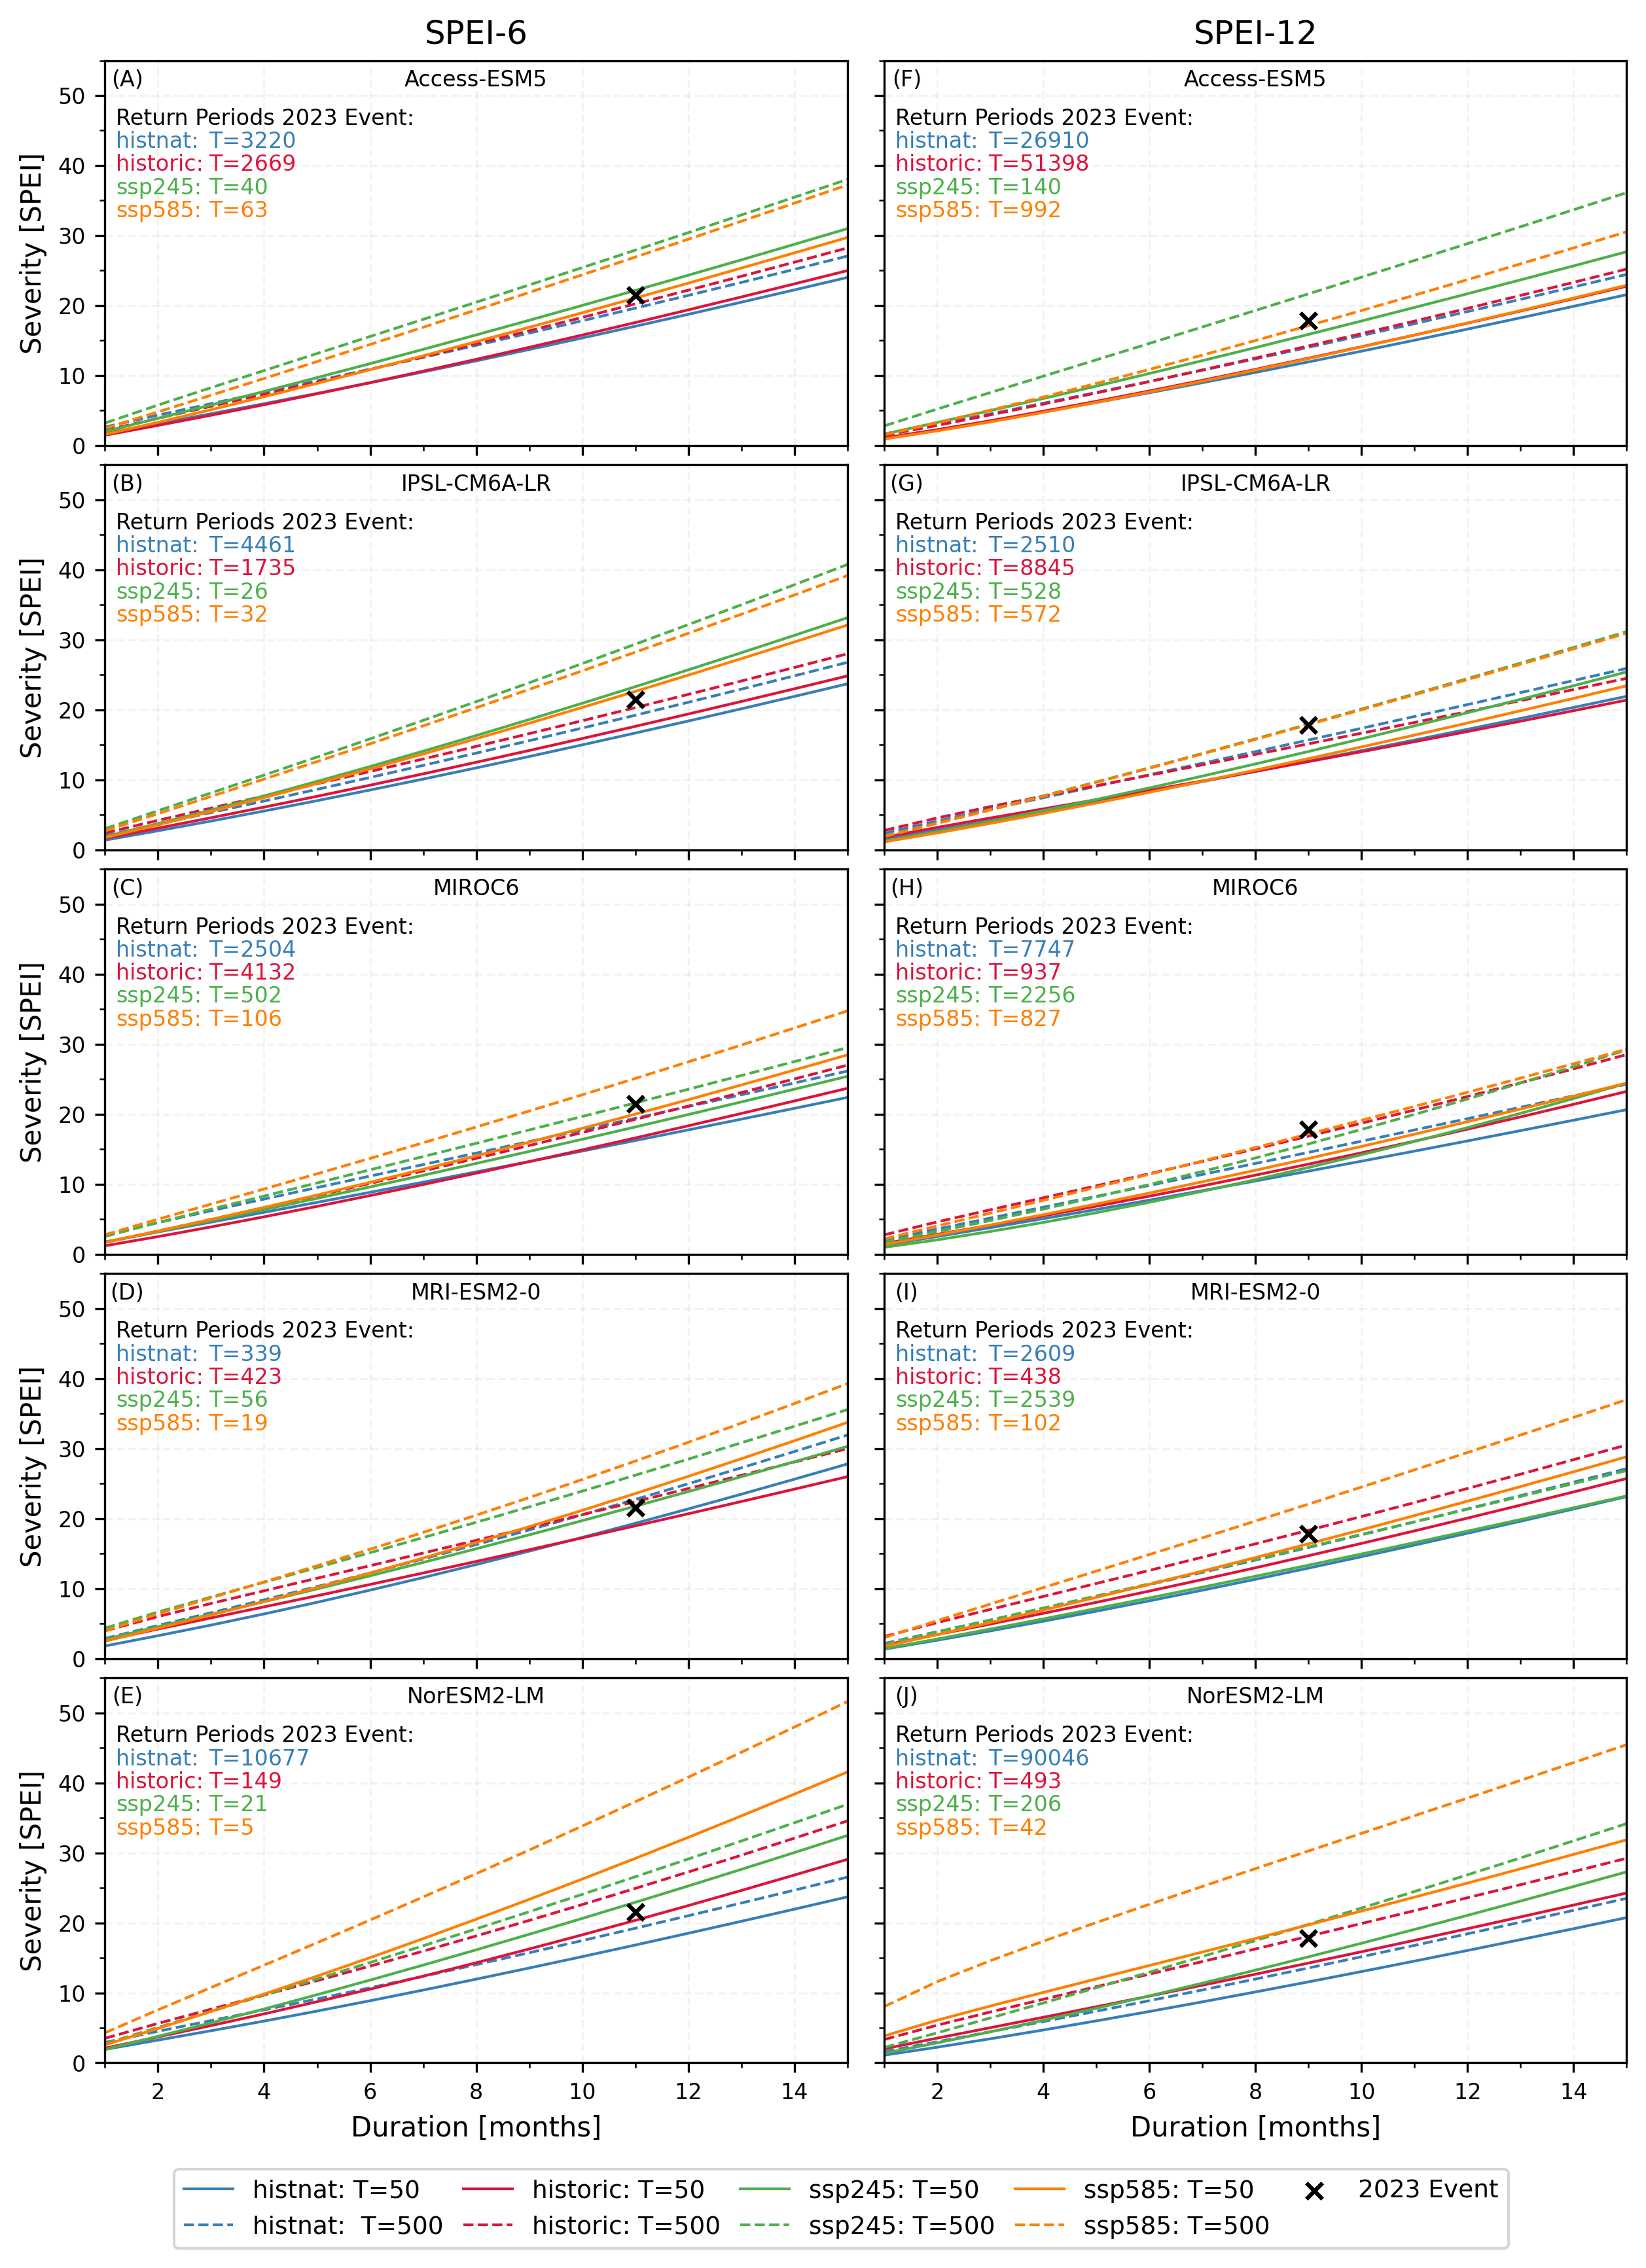

In [9]:
fig, ax = plt.subplots(ncols = 2, nrows = len(model_names_pass),figsize=(10,15),dpi = 300,sharey="row",sharex="col")
fig.subplots_adjust(wspace=0.05)
fig.subplots_adjust(hspace=0.05)
tester=0
return_time_M6 = np.zeros((2,len(model_names_pass),4,num_repeat))
return_time_M12 = np.zeros((2,len(model_names_pass),4,num_repeat))

#Loop through all models which pass the evaluation
for mod in np.arange(0,len(model_names_pass),1):
    M6_spei_str = str(6)
    M12_spei_str = str(12)
    s_str = str(region)
    model_str = model_names_pass[mod]
    
    #SPEI-6
    #histnat
    fn_spei_histnat = dir_data + model_str + "nSPEI_HG85_cal1980_2010/spei_M" + M6_spei_str + "_histnat_" + s_str + ".nc"
    spei_histnat_raw = xr.open_dataset(fn_spei_histnat)
    spei_histnat = spei_histnat_raw.spei
    spei_histnat_arr_M6 = spei_histnat.to_numpy()
    time_spei_histnat_arr_M6 = spei_histnat.time.astype("datetime64[ns]").to_numpy()
    #historic
    fn_spei_historic = dir_data + model_str + "nSPEI_HG85_cal1980_2010/spei_M" + M6_spei_str + "_historic_" + s_str + ".nc"
    spei_historic_raw = xr.open_dataset(fn_spei_historic)
    spei_historic = spei_historic_raw.where(spei_historic_raw['time.year'] >= 1950, drop=True).spei
    spei_historic_arr_M6 = spei_historic.to_numpy()
    time_spei_historic_arr_M6 = spei_historic.time.astype("datetime64[ns]").to_numpy()
    #ssp245
    fn_spei_ssp245 = dir_data + model_str + "nSPEI_HG85_cal2040_2070/spei_M" + M6_spei_str + "_ssp245_" + s_str + ".nc"
    spei_ssp245_raw = xr.open_dataset(fn_spei_ssp245)
    spei_ssp245 = spei_ssp245_raw.spei
    spei_ssp245_arr_M6 = spei_ssp245.to_numpy()
    time_spei_ssp245_arr_M6 = spei_ssp245.time.astype("datetime64[ns]").to_numpy()
    #ssp585
    fn_spei_ssp585 = dir_data + model_str + "nSPEI_HG85_cal2040_2070/spei_M" + M6_spei_str + "_ssp585_" + s_str + ".nc"
    spei_ssp585_raw = xr.open_dataset(fn_spei_ssp585)
    spei_ssp585 = spei_ssp585_raw.spei
    spei_ssp585_arr_M6 = spei_ssp585.to_numpy()
    time_spei_ssp585_arr_M6 = spei_ssp585.time.astype("datetime64[ns]").to_numpy()
    
    simulation_spei_M6 = [spei_histnat_arr_M6,spei_historic_arr_M6,spei_ssp245_arr_M6,spei_ssp585_arr_M6]
    simulation_time_M6 = [time_spei_histnat_arr_M6,time_spei_historic_arr_M6,time_spei_ssp245_arr_M6,time_spei_ssp585_arr_M6]
    
    #SPEI-12
    #histnat
    fn_spei_histnat = dir_data + model_str + "nSPEI_HG85_cal1980_2010/spei_M" + M12_spei_str + "_histnat_" + s_str + ".nc"
    spei_histnat_raw = xr.open_dataset(fn_spei_histnat)
    spei_histnat = spei_histnat_raw.spei
    spei_histnat_arr_M12 = spei_histnat.to_numpy()
    time_spei_histnat_arr_M12 = spei_histnat.time.astype("datetime64[ns]").to_numpy()
    #historic
    fn_spei_historic = dir_data + model_str + "nSPEI_HG85_cal1980_2010/spei_M" + M12_spei_str + "_historic_" + s_str + ".nc"
    spei_historic_raw = xr.open_dataset(fn_spei_historic)
    spei_historic = spei_historic_raw.where(spei_historic_raw['time.year'] >= 1950, drop=True).spei
    spei_historic_arr_M12 = spei_historic.to_numpy()
    time_spei_historic_arr_M12 = spei_historic.time.astype("datetime64[ns]").to_numpy()
    #ssp245
    fn_spei_ssp245 = dir_data + model_str + "nSPEI_HG85_cal2040_2070/spei_M" + M12_spei_str + "_ssp245_" + s_str + ".nc"
    spei_ssp245_raw = xr.open_dataset(fn_spei_ssp245)
    spei_ssp245 = spei_ssp245_raw.spei
    spei_ssp245_arr_M12 = spei_ssp245.to_numpy()
    time_spei_ssp245_arr_M12 = spei_ssp245.time.astype("datetime64[ns]").to_numpy()
    #ssp585
    fn_spei_ssp585 = dir_data + model_str + "nSPEI_HG85_cal2040_2070/spei_M" + M12_spei_str + "_ssp585_" + s_str + ".nc"
    spei_ssp585_raw = xr.open_dataset(fn_spei_ssp585)
    spei_ssp585 = spei_ssp585_raw.spei
    spei_ssp585_arr_M12 = spei_ssp585.to_numpy()
    time_spei_ssp585_arr_M12 = spei_ssp585.time.astype("datetime64[ns]").to_numpy()
    
    simulation_spei_M12 = [spei_histnat_arr_M12,spei_historic_arr_M12,spei_ssp245_arr_M12,spei_ssp585_arr_M12]
    simulation_time_M12 = [time_spei_histnat_arr_M12,time_spei_historic_arr_M12,time_spei_ssp245_arr_M12,time_spei_ssp585_arr_M12]
    
    #temporary files to store the data to  plot the graphs
    Sev_SDF_M6_histnat = np.zeros((len(return_T),num_repeat, len(np.arange(1,dur_plot+1,1))))
    Sev_SDF_M6_historic = np.zeros((len(return_T),num_repeat, len(np.arange(1,dur_plot+1,1))))
    Sev_SDF_M6_ssp245 = np.zeros((len(return_T),num_repeat, len(np.arange(1,dur_plot+1,1))))
    Sev_SDF_M6_ssp585 = np.zeros((len(return_T),num_repeat, len(np.arange(1,dur_plot+1,1))))
    sim_SDF_M6 = [Sev_SDF_M6_histnat,Sev_SDF_M6_historic,Sev_SDF_M6_ssp245,Sev_SDF_M6_ssp585]
    Sev_SDF_M12_histnat = np.zeros((len(return_T),num_repeat, len(np.arange(1,dur_plot+1,1))))
    Sev_SDF_M12_historic = np.zeros((len(return_T),num_repeat, len(np.arange(1,dur_plot+1,1))))
    Sev_SDF_M12_ssp245 = np.zeros((len(return_T),num_repeat, len(np.arange(1,dur_plot+1,1))))
    Sev_SDF_M12_ssp585 = np.zeros((len(return_T),num_repeat, len(np.arange(1,dur_plot+1,1))))
    sim_SDF_M12 = [Sev_SDF_M12_histnat,Sev_SDF_M12_historic,Sev_SDF_M12_ssp245,Sev_SDF_M12_ssp585]
        
    simulation_spei = [simulation_spei_M6,simulation_spei_M12]
    simulation_time =[simulation_time_M6,simulation_time_M12]
    sim_SDF = [sim_SDF_M6,sim_SDF_M12]
    
    # Define and set the seed for reproducibility
    seed_value = 42
    
    #Necessary to ensure the same selection for Duration and Severity as it the combination is fixed (Severity-Duration-Pair)
    rng_1_D = np.random.RandomState(seed_value)
    rng_1_S = np.random.RandomState(seed_value)
    rng_2_D = np.random.RandomState(seed_value)
    rng_2_S = np.random.RandomState(seed_value)
    
    rng_D=[rng_1_D,rng_2_D]
    rng_S=[rng_1_S,rng_2_S]

    #Loop through the aggregation periods
    for agg_m in np.arange(0,2,1):
        return_time = return_time_M6
        rng_agg_D = rng_D[agg_m]
        rng_agg_S = rng_S[agg_m]
        D_event = D_event_arr[agg_m]
        S_event = S_event_arr[agg_m]
        
        #Loop through the experiments
        for exp in np.arange(0,4):
            exp_name = ["histnat","historic","ssp245","ssp585"]
            spei_index = simulation_spei[agg_m][exp]
            simulation_time_index = simulation_time[agg_m][exp]

            D_spei, S_spei = get_SPEI_Duration_and_Severity_RunTheory(spei_index)    
            Duration = pd.Series(D_spei, name='Duration')
            Severity = pd.Series(S_spei, name='Severity')
            D_S_array = pd.concat([Duration, Severity], axis=1)
            
            num_samples = len(D_S_array['Duration'])

            alpha = 1 - ci
            
            #Loop through the number of repetitions for the bootstrapping
            for num in np.arange(0,num_repeat,1):
                D_resampled = rng_agg_D.choice(D_S_array['Duration'],size=num_samples,replace=True)
                S_resampled = rng_agg_S.choice(D_S_array['Severity'],size=num_samples,replace=True)

                #Fitting D
                param_D = dist_D.fit(D_resampled,floc=0)
                if dist_D.name == 'lognorm':
                    fitted_D = sk_uni.lognorm.fit(D_resampled,param_D)
                if dist_D.name == 'gamma':
                    fitted_D = sk_uni.gamma.fit(D_resampled,param_D)
                #Fitting S
                param_S = dist_S.fit(S_resampled,floc=0)
                if dist_S.name == 'lognorm':
                    fitted_S = sk_uni.lognorm.fit(S_resampled,param_S)

                #define univariate Distribution
                marg_dist={0:fitted_D,1:fitted_S}

                #To prevent warnings of "overflow encountered in power"
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    fitted_copula_gumble = gumbel_copula.fit(
                        data=D_S_array, method='mle',
                        univariate_fitter_options={'significant': False}, show_progress=False,mdists=marg_dist)
                #Length of array
                n = len(S_resampled)
                #Timeperiod under consideration
                diff = simulation_time_index[-1] - simulation_time_index[0] #!!!!CAREFULL HERE!!!!!
                N=diff.astype('timedelta64[Y]').astype('int')+1 #As it round offs but actually it should round up if it 29.9 years
                #Define till which month should be plotted +1 because of implementation
                dur_threshold = dur_plot +1
                #Set up array to safe results
                #sev_M1_histnat = sim_SDF[s]
                for T in np.arange(0,len(return_T),1):
                    return_Time = return_T[T]
                    #calc return
                    r = 1 - N / (n * return_Time)
                    #give Duration range
                    dur_M1_histnat = np.arange(1,dur_threshold,1)
                    #calc fitted univariate duration curve
                    u1 = fitted_copula_gumble.mdists[0].cdf(dur_M1_histnat)
                    v1 = fitted_copula_gumble.mdists[1].cdf(S_event)
                    #load gumble fitting parameters !!!! Change here if other Copula is used but also equation below
                    copula_para = fitted_copula_gumble.copula_params
                    #Create Temporay value for severity
                    v = np.zeros(len(u1))
                    #Solve conditional gumble equation for all duration values for severity !!!! Change here if other Copula is used
                    for j in np.arange(0,len(u1),1):
                        def cond_gumbel(x):
                            D_cdf = u1[j]
                            return 1/D_cdf * np.exp(-(((-np.log(D_cdf))**copula_para.theta)+(-np.log(x))**copula_para.theta)**(1/copula_para.theta))*(1+((-np.log(x))/(-np.log(D_cdf)))**copula_para.theta)**(-1+(1/copula_para.theta))-r
                        #V = fsolve(cond_gumbel,u1[j]) -> uses other algorithm than Matlab...
                        with warnings.catch_warnings():
                            warnings.simplefilter("ignore")
                            V_root = optimize.root(cond_gumbel,u1[j],method='lm').x
                        v[j] = V_root[0]
                    #get the final severity values through the inverse cdf function
                    sim_SDF[agg_m][exp][T][num] = fitted_copula_gumble.mdists[1].ppf(v)
                    
                #For calc of event
                u1_T = fitted_copula_gumble.mdists[0].cdf(D_event)
                v1_T = fitted_copula_gumble.mdists[1].cdf(S_event) 
                
                # This code snippit calculates the return period for the specific drought characteristics of the analysed
                # Extreme Drought Event
                def cond_gumbel_T(x):
                    C = 1/u1_T * np.exp(-(((-np.log(u1_T))**copula_para.theta)+(-np.log(v1_T))**copula_para.theta)**(1/copula_para.theta))*(1+((-np.log(v1_T))/(-np.log(u1_T)))**copula_para.theta)**(-1+(1/copula_para.theta))
                    return (N / (n *(1 - C))) - x
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    return_time[agg_m][mod][exp][num] = optimize.root(cond_gumbel_T,u1_T,method='lm').x[0]
        
        #Plot the panels step by step
        ax[mod][agg_m].plot(dur_M1_histnat, np.mean(sim_SDF[agg_m][0][0], axis=0), color='#377eb8',lw=1)
        ax[mod][agg_m].plot(dur_M1_histnat, np.mean(sim_SDF[agg_m][0][1], axis=0), color='#377eb8',lw=1,ls='--')
        ax[mod][agg_m].plot(dur_M1_histnat, np.mean(sim_SDF[agg_m][1][0], axis=0), color='crimson',lw=1,ls="solid")
        ax[mod][agg_m].plot(dur_M1_histnat, np.mean(sim_SDF[agg_m][1][1], axis=0), color='crimson',lw=1,ls='--')
        ax[mod][agg_m].plot(dur_M1_histnat, np.mean(sim_SDF[agg_m][2][0], axis=0), color='#4daf4a',lw=1,ls="solid")
        ax[mod][agg_m].plot(dur_M1_histnat, np.mean(sim_SDF[agg_m][2][1], axis=0), color='#4daf4a',lw=1,ls='--')
        ax[mod][agg_m].plot(dur_M1_histnat, np.mean(sim_SDF[agg_m][3][0], axis=0), color='#ff7f00',lw=1,ls="solid")
        ax[mod][agg_m].plot(dur_M1_histnat, np.mean(sim_SDF[agg_m][3][1], axis=0), color='#ff7f00',lw=1,ls='--')
        
        #Labeling:
        for r in np.arange(0,5,1):
            ax[mod][0].set_ylabel(r'Severity [SPEI]',fontsize='10')
        ax[4][0].set_xlabel(r'Duration [months]',fontsize='10')
        ax[4][1].set_xlabel(r'Duration [months]',fontsize='10')
        ax[0][0].set_title("SPEI-6",fontsize='12')
        ax[0][1].set_title("SPEI-12",fontsize='12')
        
        #Axis
        xmax=15
        ymax=55
        ax[mod][agg_m].set_xlim(1, xmax)
        ax[mod][agg_m].set_ylim(0,ymax)
        ax[mod][agg_m].xaxis.set_major_locator(MultipleLocator(2))# defines setting of the small ticks
        ax[mod][agg_m].xaxis.set_minor_locator(MultipleLocator(1))# defines setting of the small ticks
        ax[mod][agg_m].yaxis.set_major_locator(MultipleLocator(10))# defines setting of the small ticks
        ax[mod][agg_m].yaxis.set_minor_locator(MultipleLocator(5))# defines setting of the small ticks
        
        #Model Name
        label_mod = "{}".format(names_clear[mod])
        ax[mod][agg_m].annotate(names_clear[mod], xy=(0.5, 0.95), xycoords='axes fraction',
                      fontsize=8, ha='center', va='center')
        
        #Legend, Return period
        label_histnat = "Return Periods 2023 Event:"
        ax[mod][agg_m].annotate(label_histnat, xy=(0.015, 0.85), xycoords='axes fraction',
                      fontsize=8, ha='left', va='center', color='black')
        label_histnat = "histnat:"
        ax[mod][agg_m].annotate(label_histnat, xy=(0.015, 0.79), xycoords='axes fraction',
                      fontsize=8, ha='left', va='center', color='#377eb8')
        label_histnat_T =  "T={}".format(round(np.mean(return_time[agg_m][mod][0])))
        ax[mod][agg_m].annotate(label_histnat_T, xy=(0.14, 0.79), xycoords='axes fraction',
                      fontsize=8, ha='left', va='center', color='#377eb8')
        label_historic = "historic:"
        ax[mod][agg_m].annotate(label_historic, xy=(0.015, 0.73), xycoords='axes fraction',
                      fontsize=8, ha='left', va='center', color='crimson')
        label_historic_T =  "T={}".format(round(np.mean(return_time[agg_m][mod][1])))
        ax[mod][agg_m].annotate(label_historic_T, xy=(0.14, 0.73), xycoords='axes fraction',
                      fontsize=8, ha='left', va='center', color='crimson')
        label_ssp245 = "ssp245:"
        ax[mod][agg_m].annotate(label_ssp245, xy=(0.015, 0.67), xycoords='axes fraction',
                      fontsize=8, ha='left', va='center', color='#4daf4a')
        label_ssp245_T =  "T={}".format(round(np.mean(return_time[agg_m][mod][2])))
        ax[mod][agg_m].annotate(label_ssp245_T, xy=(0.14, 0.67), xycoords='axes fraction',
                      fontsize=8, ha='left', va='center', color='#4daf4a')
        label_ssp585 = "ssp585:"
        ax[mod][agg_m].annotate(label_ssp585, xy=(0.015, 0.61), xycoords='axes fraction',
                      fontsize=8, ha='left', va='center', color='#ff7f00')
        label_ssp585_T =  "T={}".format(round(np.mean(return_time[agg_m][mod][3])))
        ax[mod][agg_m].annotate(label_ssp585_T, xy=(0.14, 0.61), xycoords='axes fraction',
                      fontsize=8, ha='left', va='center', color='#ff7f00')
        
        #Event
        ax[mod][agg_m].scatter(D_event, S_event,c='black', s=35, marker="x",zorder=99)
        
        #Other
        ax[mod][agg_m].tick_params(axis='both', which='major', labelsize='8')
        ax[mod][agg_m].grid(True,alpha=0.15,linestyle = 'dashed')
    
#General Legend
ax[4][0].plot(0,0,color='#377eb8',lw=1,label=r"histnat: T=50")
ax[4][0].plot(0,0, color='#377eb8',lw=1,ls='--',label=r"histnat:  T=500")
ax[4][0].plot(0,0,color='crimson',lw=1,label=r"historic: T=50")
ax[4][0].plot(0,0,color='crimson',lw=1,ls='--',label=r"historic: T=500")
ax[4][0].plot(0,0,color='#4daf4a',lw=1,label=r"ssp245: T=50")
ax[4][0].plot(0,0,color='#4daf4a',lw=1,ls='--',label=r"ssp245: T=500")
ax[4][0].plot(0,0,color='#ff7f00',lw=1,label=r"ssp585: T=50")
ax[4][0].plot(0,0,color='#ff7f00',lw=1,ls='--',label=r"ssp585: T=500")
ax[4][0].scatter(9999, 99999,c='black', s=35, marker="x",zorder=99,label=r"2023 Event")

# Combine legends
handles, labels = ax[4][0].get_legend_handles_labels()
# Add a single legend below all subplots
fig.legend(handles, labels, loc='lower center', ncol=5, bbox_to_anchor=(0.5, .137), borderaxespad=0,
          columnspacing=0.8,fontsize='9')
plt.subplots_adjust(bottom=0.2)

# Add subplot labels
labels = ['(A)', '(B)', '(C)', '(D)','(E)', '(F)', '(G)', '(H)','(I)', '(J)']

# Get the total number of rows and columns
nrows, ncols = ax.shape
# Iterate over each subplot in column-major order
index_label = 0
for i in range(ncols):
    for j in range(nrows):
        axes = ax[j, i]
        axes.annotate(labels[index_label], xy=(0.03, 0.95), xycoords='axes fraction',
                  fontsize=8, ha='center', va='center')
        index_label += 1

#plt.savefig('images/return_period_models.png', bbox_inches='tight', pad_inches=0)